<a href="https://colab.research.google.com/github/hugoalexg/Python-for-Data-Science-and-Machine-Learning-Bootcamp/blob/main/20_Natural_Language_Processing_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NLP (Natural Language Processing) with Python**

This is the notebook that goes along with the NLP video lecture!
In this lecture we will discuss a higher level overview of the basics of Natural Language Processing, which basically consists of combining machine learning techniques with text, and using math and statistics to get that text in a format that the machine learning algorithms can understand!

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set()

In [ ]:
import nltk

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


Get the Data

We'll be using a dataset from the UCI datasets! This dataset is already located in the folder for this section. Let's go ahead and use rstrip() plus a list comprehension to get a list of all the lines of text messages:

In [ ]:
messages = [line.rstrip() for line in open('/content/drive/My Drive/Python for Data Science and Machine Learning Bootcamp/Files/SMSSpamCollection')]
print(len(messages))

5574


A collection of texts is also sometimes called "corpus". Let's print the first ten messages and number them using enumerate:

In [ ]:
for message_no, message in enumerate(messages[:10]):
    print(message_no, message)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though


5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv


6 ham	Even my brother is not like to speak with me. They treat me like aids patent.


7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code 


We'll use read_csv and make note of the sep argument, we can also specify the desired column names by passing in a list of names.

In [ ]:
messages = pd.read_csv('/content/drive/My Drive/Python for Data Science and Machine Learning Bootcamp/Files/SMSSpamCollection', sep='\t', names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Let's use groupby to use describe by label, this way we can begin to think about the features that separate ham and spam!

In [ ]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of feature engineering. The better your domain knowledge on the data, the better your ability to engineer more features from it. Feature engineering is a very large part of spam detection in general. I encourage you to read up on the topic!

Let's make a new column to detect how long the text messages are:

In [ ]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


**Data Visualization**

Let's visualize this! Let's do the imports:

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


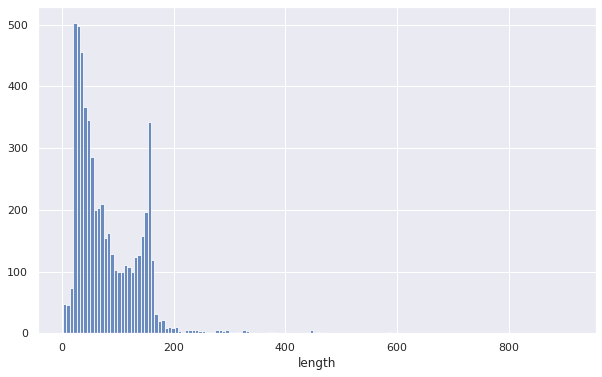

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(messages['length'], kde=False, bins=150, color='b',hist_kws={'alpha': 0.8})
plt.show()

In [ ]:
messages.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

Woah! 910 characters, let's use masking to find this message:

In [ ]:
messages[messages['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

 let's focus back on the idea of trying to see if message length is a distinguishing feature between ham and spam:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f43ea6c53c8>,
      dtype=object)

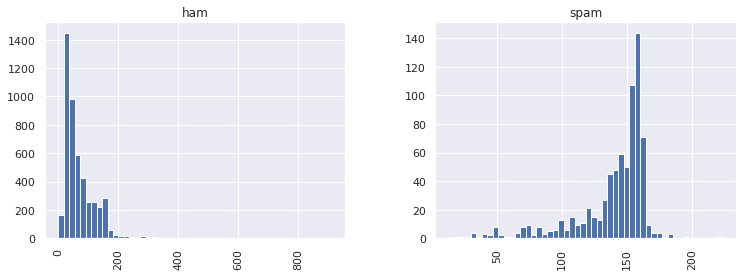

In [ ]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4))

Very interesting! Through just basic EDA we've been able to discover a trend that spam messages tend to have more characters.

**Text Pre-processing**

Let's create a function that will process the string in the message column, then we can just use apply() in pandas do process all the text in the DataFrame.
First removing punctuation. We can just take advantage of Python's built-in string library to get a quick list of all the possible punctuation:

In [ ]:
import string

mess = 'Sample message! Notice: it has punctuation.'
nopunc = [char for char in mess if char not in string.punctuation] # Check characters to see if they are in punctuation
nopunc = ''.join(nopunc) # Join the characters again to form the string.
print(nopunc)

Sample message Notice it has punctuation


In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords.words('english')[0:10]# Show some stop words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [ ]:
nopunc.split()

['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

In [ ]:
# Now just remove any stopwords
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
clean_mess

['Sample', 'message', 'Notice', 'punctuation']

Now let's put both of these together in a function to apply it to our DataFrame later on:

In [ ]:
def text_process(mess):   
    nopunc = [char for char in mess if char not in string.punctuation] # Check characters to see if they are in punctuation   
    nopunc = ''.join(nopunc) # Join the characters again to form the string. 
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')] # Now just remove any stopwords


Here is the original DataFrame again:

In [ ]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Now let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

Let's see an example output on on column:

In [ ]:
# Check to make sure its working
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object


**Vectorization**

Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.
Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.
We'll do that in three steps using the bag-of-words model:

-Count how many times does a word occur in each message (Known as term frequency)

-Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

-Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# Might take awhile...
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])
# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

11425


In [ ]:
print(bow_transformer.vocabulary_)

{'Go': 2060, 'jurong': 7555, 'point': 8917, 'crazy': 5769, 'Available': 1110, 'bugis': 5218, 'n': 8336, 'great': 6937, 'world': 11163, 'la': 7668, 'e': 6217, 'buffet': 5217, 'Cine': 1483, 'got': 6906, 'amore': 4653, 'wat': 10965, 'Ok': 3064, 'lar': 7701, 'Joking': 2451, 'wif': 11072, 'u': 10698, 'oni': 8590, 'Free': 1941, 'entry': 6331, '2': 423, 'wkly': 11123, 'comp': 5619, 'win': 11084, 'FA': 1833, 'Cup': 1551, 'final': 6557, 'tkts': 10512, '21st': 443, 'May': 2804, '2005': 430, 'Text': 3953, '87121': 871, 'receive': 9252, 'questionstd': 9159, 'txt': 10686, 'rateTCs': 9200, 'apply': 4731, '08452810075over18s': 73, 'U': 4068, 'dun': 6204, 'say': 9554, 'early': 6222, 'hor': 7186, 'c': 5261, 'already': 4629, 'Nah': 2948, 'dont': 6123, 'think': 10433, 'goes': 6877, 'usf': 10799, 'lives': 7842, 'around': 4777, 'though': 10450, 'FreeMsg': 1943, 'Hey': 2222, 'darling': 5864, '3': 543, 'weeks': 11011, 'word': 11150, 'back': 4893, 'Id': 2346, 'like': 7800, 'fun': 6755, 'still': 10093, 'Tb': 3


Let's take one text message and get its bag-of-words counts as a vector, putting to use our new bow_transformer:

In [ ]:
message4 = messages['message'][3]
print(message4)

U dun say so early hor... U c already then say...


In [ ]:
print(text_process(message4))

['U', 'dun', 'say', 'early', 'hor', 'U', 'c', 'already', 'say']


Now let's see its vector representation:

In [ ]:
bow4 = bow_transformer.transform([message4])
print(bow4)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2


In [ ]:
print(bow4.shape)

(1, 11425)



This means that there are seven unique words in message number 4 (after removing common stop words). Two of them appear twice, the rest only once. Let's go ahead and check and confirm which ones appear twice:

In [ ]:
print(bow_transformer.get_feature_names()[4068])
print(bow_transformer.get_feature_names()[9554])

U
say


In [ ]:
print(bow_transformer.get_feature_names())

['0', '008704050406', '0089my', '0121', '01223585236', '01223585334', '0125698789', '02', '020603', '0207', '02070836089', '02072069400', '02073162414', '02085076972', '020903', '021', '050703', '0578', '06', '060505', '061104', '07008009200', '07046744435', '07090201529', '07090298926', '07099833605', '071104', '07123456789', '0721072', '07732584351', '07734396839', '07742676969', '07753741225', '0776xxxxxxx', '07786200117', '077xxx', '078', '07801543489', '07808', '07808247860', '07808726822', '07815296484', '07821230901', '0784987', '0789xxxxxxx', '0794674629107880867867', '0796XXXXXX', '07973788240', '07XXXXXXXXX', '07xxxxxxxxx', '0800', '08000407165', '08000776320', '08000839402', '08000930705', '08000938767', '08001950382', '08002888812', '08002986030', '08002986906', '08002988890', '08006344447', '0808', '08081263000', '08081560665', '0825', '0844', '08448350055', '08448714184', '0845', '08450542832', '08452810071', '08452810073', '08452810075over18s', '0870', '08700621170150p',


Now we can use .transform on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Let's go ahead and check out how the bag-of-words counts for the entire SMS corpus is a large, sparse matrix:

In [ ]:
messages_bow = bow_transformer.transform(messages['message'])

In [ ]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548


In [ ]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0



After the counting, the term weighting and normalization can be done with TF-IDF, using scikit-learn's TfidfTransformer.

So what is TF-IDF?
TF-IDF stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 9554)	0.5385626262927564
  (0, 7186)	0.4389365653379857
  (0, 6222)	0.3187216892949149
  (0, 6204)	0.29953799723697416
  (0, 5261)	0.29729957405868723
  (0, 4629)	0.26619801906087187
  (0, 4068)	0.40832589933384067


In [ ]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['dog']])

7.546247245889701


To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [ ]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11425)


**Training a model**

With messages represented as vectors, we can finally train our spam/ham classifier. Now we can actually use almost any sort of classification algorithms. For a variety of reasons, the Naive Bayes classifier algorithm is a good choice.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])


Let's try classifying our single random message and checking how we do:

In [ ]:
print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected:', messages.label[3])

predicted: ham
expected: ham


Train Test Split


In [ ]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = train_test_split(messages['message'], messages['label'], test_size=0.2)

In [ ]:
print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


**Creating a Data Pipeline**

Let's run our model again and then predict off the test set. We will use SciKit Learn's pipeline capabilities to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. Let's see an example of how it works:

In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

Now we can directly pass message text data and the pipeline will do our pre-processing for us! We can treat it as a model/estimator API:

In [ ]:
pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7f43ea021048>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
predictions = pipeline.predict(msg_test)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      1000
        spam       0.75      1.00      0.86       115

    accuracy                           0.97      1115
   macro avg       0.88      0.98      0.92      1115
weighted avg       0.97      0.97      0.97      1115



In [ ]:
print(confusion_matrix(predictions,label_test))

[[962  38]
 [  0 115]]
